# Anime Recommender System

This is a competition from [kaggle](https://www.kaggle.com/datasets/CooperUnion/anime-recommendations-database/data).<br>
You can find more information about the dataset in the above link. 

The **main goal** is building a better anime recommendation system based only on user viewing history. <br>
Therefore, I am going to implement a **Collaborative Filtering** technique.


In [14]:
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from surprise import SVD
from surprise import Reader
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import train_test_split

from collections import defaultdict

warnings.filterwarnings("ignore")

In [2]:
# Load datasets
anime_info_data = pd.read_csv("data/anime.csv")
anime_ratings_data = pd.read_csv("data/rating.csv")

display(anime_info_data.head())
display(anime_ratings_data.head())

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


## Data Preparation

- Keep not rated values as a separate dataset for further use.

In [3]:
#. Select watched-not-rating
non_rating_data = anime_ratings_data[anime_ratings_data["rating"] == -1]

#. Select rating-data
anime_ratings_data = anime_ratings_data[
    ~anime_ratings_data.index.isin(non_rating_data.index)]

## Anime Recommender System

For the recommender system, I used **collaborating filtering** to recommend animes.

<Figure size 1600x600 with 0 Axes>

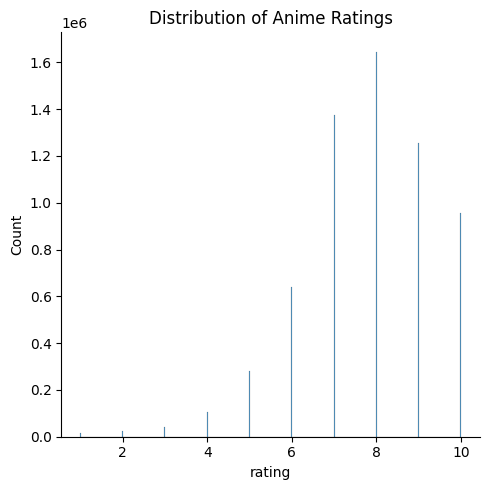

In [4]:
#. Plot distribution of movie ratings
plt.figure(figsize=(16,6))

ax = sns.displot(data=anime_ratings_data, x="rating")
ax.set(title="Distribution of Anime Ratings")
plt.tight_layout();

### Prerare dataset

- Create reader object
- Select features and load the data into a Dataset object.
- Split the data into train and test datasets.

In [5]:
#. Suprise reader
reader = Reader(rating_scale=(1,10))

#. Load data as Dataset object
rating_features = ["user_id", "anime_id", "rating"]
data = Dataset.load_from_df(anime_ratings_data[rating_features], reader)

#. Split data
trainset, testset = train_test_split(data=data, test_size=.20)

### Train model

- Train a Singular Value Decomposition (SVD) model

In [24]:
recommendation_model = SVD()
recommendation_model.fit(trainset)
predictions = recommendation_model.test(testset)

#. Check metrics
accuracy.rmse(predictions)
accuracy.mae(predictions);

RMSE: 1.1333
MAE:  0.8447


### Postprocessing recommendations

- Get predictions/recommendations.
- Remove the animes that the user watched, but didn't rate.
- Sort the results.
- Select the Top-5 recommendations.
- Merge recommendations and anime information.

In [13]:
%%time

#. Group estimations
predictions_group = defaultdict(list)
for uid, iid, true_r, est, _ in predictions:
    predictions_group[uid].append((iid, est))    

num_rec = 5
anime_recommendations = pd.DataFrame()

for uid, user_ratings in predictions_group.items():
    #. Remove watched-non-rated animes
    user_non_rated = non_rating_data.loc[
        non_rating_data["user_id"] == uid, "anime_id"].to_list()
    mask = [val not in user_non_rated for val in user_ratings]
    mask = np.array(mask, dtype=np.bool_)
    user_ratings = np.array(user_ratings)[mask]
    
    #. Create DataFrame
    n = len(user_ratings)
    udf = pd.DataFrame([uid]*n, columns=["user_id"])
    udf.loc[:,"anime_id"] = [val[0] for val in user_ratings]
    udf.loc[:,"rating_est"] = [val[1] for val in user_ratings]
    
    #. Append recommendations
    anime_recommendations = pd.concat(
        [anime_recommendations, udf], ignore_index=True)
    
#. Sort recommendations
anime_recommendations = anime_recommendations.sort_values(
    ["user_id", "rating_est"], ascending=False)

#. Select recommendations
num_rec = 5
anime_recommendations_sel = anime_recommendations\
   .groupby("user_id").head(num_rec).reset_index(drop=True)

#. Data Transformations
anime_recommendations_sel["anime_id"] = anime_recommendations_sel["anime_id"].astype(int)
anime_recommendations_sel["rating_est"] = anime_recommendations_sel["rating_est"].round(2)

#. Merge datasets
anime_features = ["anime_id", "name", "genre", "type"]
anime_recommendations_res = pd.merge(
    anime_recommendations_sel, 
    anime_info_data[anime_features], on="anime_id", how="left")

display(anime_recommendations_res.head(5))

,user_id,anime_id,rating_est,name,genre,type
0,73515,5205,10.00,Kara no Kyoukai 7: Satsujin Kousatsu (Kou),"Action, Mystery, Romance, Supernatural, Thriller",Movie
1,73515,1,9.76,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV
2,73515,1575,9.68,Code Geass: Hangyaku no Lelouch,"Action, Mecha, Military, School, Sci-Fi, Super...",TV
3,73515,5,9.62,Cowboy Bebop: Tengoku no Tobira,"Action, Drama, Mystery, Sci-Fi, Space",Movie
4,73515,3784,9.61,Evangelion: 2.0 You Can (Not) Advance,"Action, Mecha, Sci-Fi",Movie


CPU times: user 2min 26s, sys: 1.16 s, total: 2min 27s
Wall time: 2min 27s


## Check results

- Pick a random user.
- Select user recommendations
- Show recommendations.

In [19]:
#. Select user
users = anime_recommendations_res["user_id"].unique()
user_id = random.choice(users)

#. Select user recommendations
user_recommendations = anime_recommendations_res[
    anime_recommendations_res["user_id"] == user_id]

display(user_recommendations)

,user_id,anime_id,rating_est,name,genre,type
1623,73050,4155,9.88,One Piece Film: Strong World,"Action, Adventure, Comedy, Drama, Fantasy, Sho...",Movie
1624,73050,4898,9.81,Kuroshitsuji,"Action, Comedy, Demons, Fantasy, Historical, S...",TV
1625,73050,16904,9.80,K: Missing Kings,"Action, Super Power, Supernatural",Movie
1626,73050,21995,9.47,Ao Haru Ride,"Comedy, Drama, Romance, School, Shoujo, Slice ...",TV
1627,73050,22125,9.41,Kuroko no Basket: Mou Ikkai Yarimasen ka,"Comedy, School, Shounen, Sports",Special


### Save results
- Save the results into a parquet file.

In [25]:
anime_recommendations_res.to_parquet("data/recommendations_results.parquet")

___